In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Búsqueda inicial

In [2]:
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 3142

import numpy as np
np.random.seed(algorithm_globals.random_seed)

from qiskit_machine_learning.datasets import ad_hoc_data

train_data, train_labels, test_data, test_labels= (
    ad_hoc_data(training_size=20, test_size=5, n=2, gap=0.3, one_hot=False))

# Búsqueda 1

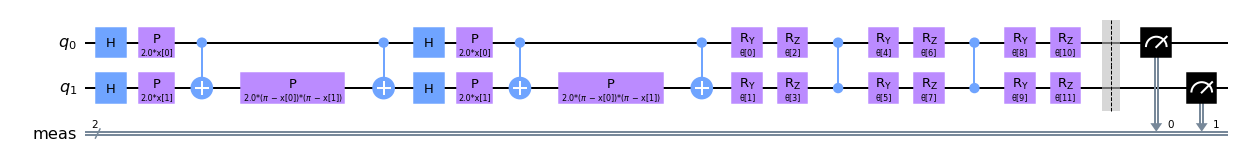

In [3]:
from qiskit.circuit.library import ZZFeatureMap, TwoLocal

adhoc_feature_map = ZZFeatureMap(feature_dimension=2, reps=2)
adhoc_var_form = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

adhoc_circuit = adhoc_feature_map.compose(adhoc_var_form)
adhoc_circuit.measure_all()
adhoc_circuit.decompose().draw()

In [ ]:
def circuit_parameters(data, variational):
    parameters = {}
    for i, p in enumerate(adhoc_feature_map.ordered_parameters):
        parameters[p] = data[i]
    for i, p in enumerate(adhoc_var_form.ordered_parameters):
        parameters[p] = variational[i]
    return parameters

In [ ]:
def assign_label(bitstring):
    hamming_weight = sum([int(k) for k in list(bitstring)])
    odd = hamming_weight & 1
    if odd:
        return 0
    else:
        return 1

# Búsqueda 2

In [ ]:
def label_probability(results):
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = assign_label(bitstring)
        probabilities[label] += counts / shots
        print(probabilities)
    return probabilities

# Búsqueda 3

In [ ]:
from qiskit import BasicAer, execute

def classification_probability(data, variational):
    circuits = [adhoc_circuit.assign_parameters(
        circuit_parameters(d,variational)) for d in data]
    backend = BasicAer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    classification = [label_probability(results.get_counts(c)) for c in circuits]
    return classification

# Búsqueda 4

In [ ]:
def cross_entropy_loss(predictions, expected):
    p = predictions.get(expected)
    return -(expected*np.log(p)+(1-expected)*np.log(1-p))
   
def cost_function(data, labels, variational):
    classifications = classification_probability(data, variational)

    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)

    return cost

In [ ]:
# Callback function for optimiser for plotting purposes
def store_intermediate_result(evaluation, parameter, cost, 
                              stepsize, accept):
    evaluations.append(evaluation)
    parameters.append(parameter)
    costs.append(cost)

# Búsqueda 5

In [ ]:
# Set up the optimization
from qiskit.algorithms.optimizers import SPSA

parameters = []
costs = []
evaluations = []

optimizer = SPSA(maxiter=100, callback=store_intermediate_result)

# Búsqueda 6

In [ ]:
initial_point = np.random.random(adhoc_var_form.num_parameters)
#initial_point = np.array([3.28559355, 5.48514978, 5.13099949,
#                          0.88372228, 4.08885928, 2.45568528,
#                          4.92364593, 5.59032015, 3.66837805,
#                          4.84632313, 3.60713748, 2.43546])

objective_function = lambda variational: cost_function(train_data,
                                                       train_labels,
                                                       variational)

# Run the optimization
opt_var, opt_value, _ = optimizer.optimize(len(initial_point), objective_function, initial_point=initial_point)

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

In [ ]:
def score_classifier(data, labels, variational):
    probability = classification_probability(data, variational)

    prediction = [0 if p[0] >= p[1] else 1 for p in probability]
    
    accuracy = 0
    for i, p in enumerate(probability):
        if (p[0] >= p[1]) and (labels[i] == 0):
            accuracy += 1
        elif (p[1]) >= p[0] and (labels[i] == 1):
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

accuracy, prediction = score_classifier(test_data, test_labels, opt_var)
accuracy

In [ ]:
from matplotlib.lines import Line2D
plt.figure(figsize=(9, 6))

for feature, label in zip(train_data, train_labels):
    marker = 'o' 
    color = 'C0' if label == 0 else 'C1'
    plt.scatter(feature[0], feature[1],
                marker=marker, s=100, color=color)
    
for feature, label, pred in zip(test_data, test_labels, prediction):
    marker = 's' 
    color = 'C0' if pred == 0 else 'C1'
    plt.scatter(feature[0], feature[1],
                marker=marker, s=100, color=color)
    if label != pred:  # mark wrongly classified
        plt.scatter(feature[0], feature[1], marker='o', s=500,
                    linewidths=2.5, facecolor='none', edgecolor='C3')

legend_elements = [
    Line2D([0], [0], marker='o', c='w', mfc='C0', label='A', ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='C0', label='B', ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C1', label='predict A',
           ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C0', label='predict B',
           ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='none', mec='C3',
           label='wrongly classified', mew=2, ms=15)
]

plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1),
           loc='upper left')
    
plt.title('Training & Test Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(train_labels.reshape(-1, 1)).toarray()
test_labels_oh = encoder.fit_transform(test_labels.reshape(-1, 1)).toarray()

In [ ]:
parameters = []
costs = []
evaluations = []

initial_point = np.random.random(adhoc_var_form.num_parameters)
#initial_point = np.array([0.3200227 , 0.6503638 , 0.55995053,
#                          0.96566328, 0.38243769, 0.90403094,
#                          0.82271449, 0.26810137, 0.61076489,
#                          0.82301609, 0.11789148, 0.29667125])

from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(feature_map=adhoc_feature_map,
          ansatz=adhoc_var_form,
          loss='cross_entropy',
          optimizer=SPSA(callback=store_intermediate_result),
          initial_point=initial_point,
          quantum_instance=BasicAer.get_backend('qasm_simulator'))

vqc.fit(train_data, train_labels_oh)

In [ ]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

In [ ]:
vqc.score(test_data, test_labels_oh)

In [ ]:
from matplotlib.lines import Line2D
plt.figure(figsize=(9, 6))

for feature, label in zip(train_data, train_labels_oh):
    color = 'C1' if label[0] == 0 else 'C0'
    plt.scatter(feature[0], feature[1], marker='o', s=100,
                color=color)
    
for feature, label, pred in zip(test_data, test_labels_oh,
                                vqc.predict(test_data)): 
    color = 'C1' if pred[0] == 0 else 'C0'
    plt.scatter(feature[0], feature[1], marker='s', s=100, color=color)
    if not np.array_equal(label,pred):  # mark wrongly classified
        plt.scatter(feature[0], feature[1], marker='o', s=500,
                    linewidths=2.5, facecolor='none', edgecolor='C3')

legend_elements = [
    Line2D([0], [0], marker='o', c='w', mfc='C1', label='A', ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='C0', label='B', ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C1', label='predict A',
           ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C0', label='predict B',
           ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='none', mec='C3',
           label='wrongly classified', mew=2, ms=15)
]

plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1),
           loc='upper left')
    
plt.title('Training & Test Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()